<a href="https://colab.research.google.com/github/skolix15/Machine_Learning_2025/blob/main/Exercise_six_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import sys

!{sys.executable} -m pip install -U ydata-profiling[notebook]
!pip install jupyter-contrib-nbextensions
!jupyter nbextension enable --py widgetsnbextension

!pip install umap-learn

In [50]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap

warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns",
)

# Question 1

In [51]:
# Load Data
df = pd.read_csv("bankloan.csv")
# Create profile report object
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# # Appear to notebook
# profile.to_notebook_iframe()
# Save to HTML file
# profile.to_file("notebook_report.html")

# Question 2

## Subquestion 1

Mean: 15116.256  

Max: 35000

Min: 1000

## Subquestion 2

Μπορούμε να αφαιρέσουμε τις παρακάτω μεταβλητές:

(a) Μεταβλητές που λειτουργούν ως αναγνωριστικά =>
    1. id (μοναδικές τιμές),
    2. mebmer_id (μοναδικές τιμές),
    3. row_id (μοναδικές τιμές),
    4. unnamed (είναι μη υποστηριζόμενου τύπου και έχει 100% ελλειπούσες τιμές)

(b) Μεταβλητές με μεγάλο ποσοστό ελλειπούσων τιμώ =>
    5. annual_inc_joint (99.9% ελλειπούσες τιμές)
    6. dti_joint (99.9% ελλειπούσες τιμές)
    7. 36months (86.1% ελλειπούσες τιμές, είναι υψηλά συσχετισμένη με τις μεταβλητές 60months & term)
    8. 60months (86.1% ελλειπούσες τιμές, είναι υψηλά συσχετισμένη με τις μεταβλητές 36months & term)
    9. next_pymnt_d (75.5% ελλειπούσες τιμές και μη ισρροπημένο -> 98.8%)
    10. mths_since_last_major_derog (71.8% ελλειπούσες τιμές)

(c) Μεταβλητές με υψηλή συσχέτιση =>
    11. title (υψηλά συσχετισμένη με τη μεταβλητή purpose, μπορεί να αφαιρεθεί διατηρώντας την purpose)
    12. grade & sub_grade (υψηλά συσχετισμένες μεταξύ τους. Ενδεχομένως, να αρκούσε η μία από τις δύο)
    13. funded_amnt & loan_amnt (υψηλά συσχετισμένες μεταξύ τους. Ενδεχομένως, να αρκούσε η μία από τις δύο)

In [52]:
# Set variable to drop
variables_to_drop = [

  # Identifiers/Non-predictive features
  'id', 'member_id', 'Row ID', 'Unnamed: 50',

  # Variables with high percentage of missing values (>70%)
  'annual_inc_joint', 'dti_joint', '36months', '60months',
  'next_pymnt_d', 'mths_since_last_major_derog',

  # Redundant/Highly correlated variables
  'title', 'grade', 'funded_amnt'

]

# Drop the specified columns from the DataFrame
df_cleaned = df.drop(columns=variables_to_drop, axis=1)

# Print information
print(f"\nVariables dropped: {variables_to_drop}")
print(f"Cleaned DataFrame dimensions: {df_cleaned.shape}")


Variables dropped: ['id', 'member_id', 'Row ID', 'Unnamed: 50', 'annual_inc_joint', 'dti_joint', '36months', '60months', 'next_pymnt_d', 'mths_since_last_major_derog', 'title', 'grade', 'funded_amnt']
Cleaned DataFrame dimensions: (152316, 40)


## Subquestion 3

In [53]:
# Fill undefined/null values

# Get numerical columns
numerical_columns = df_cleaned.select_dtypes(include=['number']).columns

# Get categorical columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# Fill empty numerical columns with mean value
for column in numerical_columns:
  if df_cleaned[column].isnull().any():
          mean_value = df_cleaned[column].mean()
          df_cleaned[column].fillna(mean_value)

# Fill empty categorical columns with most used value (mode)
for column in categorical_columns:
    if df_cleaned[column].isnull().any():
        # Using .iloc[0] in order to get the first value, in case of multiple modes
        mode_value = df_cleaned[column].mode().iloc[0]
        df_cleaned[column].fillna(mode_value)

# Store updated/cleaned dataframe in new csv file
df_cleaned.to_csv("bankloan_cleaned.csv", index=False)
print("Updated/cleaned Dataframe was stored in 'bankloan_cleaned.csv' file!")

Updated/cleaned Dataframe was stored in 'bankloan_cleaned.csv' file!


## Subquestion 4

In [54]:
# Set target values/subgrades
target_sub_grades = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2']

# Create target column with values 0 and 1
# Target: 1 => if sub_grade is in target_sub_grades
# Target: 0 =>  otherwise
df_cleaned['target_loan_risk'] = df_cleaned['sub_grade'].apply(lambda x: 1 if x in target_sub_grades else 0)

# Calculate target counts & perchentages
target_counts = df_cleaned['target_loan_risk'].value_counts()
target_percentages = (df_cleaned['target_loan_risk'].value_counts(normalize=True) * 100).round(2).astype(str) + ' %'

# Print results
print(f"Target Counts:\n{target_counts.to_string(header=False)}\n")
print(f"Target Percentages:\n{target_percentages.to_string(header=False)}\n")

Target Counts:
0    108069
1     44247

Target Percentages:
0    70.95 %
1    29.05 %



Με βάση τα παραπάνω στατιστικά, παρατηρούμε ότι η μεταβλητή target παρουσιάζει σημαντική ανισορροπία. Η κλάση 0 (Υψηλότερος Κίνδυνος/Non-Target) κυριαρχεί με 73.06%, ενώ η κλάση 1 (Χαμηλός Κίνδυνος/Target) αποτελεί τη μειοψηφία (26.94%).

## Subquestion 5

In [55]:
# Create ranges (loan_amoun_ranges) of 2000 from the minimum to the maximum loan amount.
loan_amount_ranges = range(
    int(df_cleaned['loan_amnt'].min()),
    int(df_cleaned['loan_amnt'].max()) + 2000,
    2000
)


# Categorize each loan into the corresponding load amount ranges
# pd.cut assigns every loan_amnt value to one of the defined intervals.
df_cleaned['loan_range'] = pd.cut(df_cleaned['loan_amnt'], loan_amount_ranges)

# Calculate approval rate per loan amount range
approval_rate = df_cleaned.groupby('loan_range', observed=True)['target_loan_risk'].mean()

# Filter only the intervals where the approval probability
# is at least 0.15 (15%).
desired_amount_ranges = approval_rate[approval_rate >= 0.15]

# Print desired amount ranges
print(f"Desired amount ranges:\n\n{desired_amount_ranges}\n")


Desired amount ranges:

loan_range
(1000, 3000]      0.182173
(3000, 5000]      0.289617
(5000, 7000]      0.351811
(7000, 9000]      0.350343
(9000, 11000]     0.336225
(11000, 13000]    0.296093
(13000, 15000]    0.302218
(15000, 17000]    0.272632
(17000, 19000]    0.270025
(19000, 21000]    0.290130
(21000, 23000]    0.219370
(23000, 25000]    0.324080
(25000, 27000]    0.241345
(27000, 29000]    0.403043
(29000, 31000]    0.169950
Name: target_loan_risk, dtype: float64



# Question 3

## Normalization Method

Για την κανονικοποίηση των εισόδων στο πρόβλημα πρόβλεψης δανειοδότησης, επέλεξα τη μέθοδο StandardScaler, η οποία μετασχηματίζει κάθε αριθμητική μεταβλητή ώστε να έχει μέση τιμή 0 και τυπική απόκλιση 1. Η επιλογή αυτή έγινε διότι τα χαρακτηριστικά διαφέρουν σημαντικά σε κλίμακα και μονάδες μέτρησης, όπως για παράδειγμα το ποσό δανείου και το ετήσιο εισόδημα. Με αυτόν τον τρόπο τα μοντέλα που βασίζονται σε απόσταση ή gradient, όπως η Logistic Regression, το SVM ή το KNN, μπορούν να συγκρίνουν τις μεταβλητές με ίση βαρύτητα, ενώ ταυτόχρονα διατηρείται η σχετική κατανομή των τιμών και δεν περιορίζονται αυθαίρετα οι ακραίες τιμές, όπως θα συνέβαινε με το MinMaxScaler.

## Source Code

In [56]:
# Drop leakage
df_model = df_cleaned.drop(columns=['sub_grade'], axis=1)

# Features / target
X = df_model.drop(columns=['target_loan_risk'])
y = df_model['target_loan_risk']

# Identify feature types
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

# Build preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # fill numeric NaNs
    ('scaler', StandardScaler())                     # normalize -> mean=0, std=1
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill categorical NaNs
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True, drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_features),
        ('cat', categorical_pipeline, cat_features)
    ],
)

# Full pipeline with RandomForest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)


pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', rf)
])

# Train/test split (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

#  GridSearch
param_grid = {'clf__n_estimators': [50, 100]}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Evaluate on test set
y_pred = grid.predict(X_test)

print("Best params:", grid.best_params_)
print("Accuracy : ", round(accuracy_score(y_test, y_pred), 3))
print("Precision: ", round(precision_score(y_test, y_pred), 3))
print("Recall   : ", round(recall_score(y_test, y_pred), 3))
print("F1-score : ", round(f1_score(y_test, y_pred), 3))




Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'clf__n_estimators': 100}
Accuracy :  0.995
Precision:  1.0
Recall   :  0.982
F1-score :  0.991


## Classifiter Selection

Επέλεξα RandomForest γιατί το dataset είναι μεγάλο και περιέχει τόσο αριθμητικά όσο και κατηγορικά χαρακτηριστικά. Το RandomForest ανιχνεύει μη γραμμικές σχέσεις, είναι ανθεκτικό σε outliers, και συνήθως έχει καλύτερη απόδοση σε πολύπλοκα datasets. Η παράμετρος n_estimators ρυθμίστηκε μέσω cross-validation, καθώς είναι η πιο ευαίσθητη παράμετρος για το μοντέλο.

## Most crucial metric

Η πιο σημαντική μετρική για αυτή την εφαρμογή είναι το F1-score, καθώς εξισορροπεί Precision και Recall. Εναλλακτικά, ανάλογα με την προτεραιότητα της τράπεζας, μπορούμε να δώσουμε μεγαλύτερη έμφαση στο Precision για να ελαχιστοποιήσουμε τον κίνδυνο κακών δανειοληπτών.

# Question 4

## Subquestion 1

In [57]:
# Drop leakage
df_model = df_cleaned.drop(columns=['sub_grade'])

# Label-encode all categorical features
df_encoded = df_model.copy()
for col in df_encoded.select_dtypes(include=['object','category']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Set x and y
X = df_encoded.drop(columns=['target_loan_risk'])
y = df_encoded['target_loan_risk']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)

top15 = importances.sort_values(ascending=False).head(15)

print("\n💡 Top 15 Most Important Features:")
print(top15)



💡 Top 15 Most Important Features:
int_rate               0.718297
total_rec_int          0.056278
term                   0.037006
total_rec_prncp        0.034467
total_rev_hi_lim       0.019076
total_pymnt            0.018313
verification_status    0.016131
revol_util             0.012156
installment            0.010996
out_prncp              0.009300
last_pymnt_amnt        0.008416
purpose                0.008194
inq_last_6mths         0.007460
annual_inc             0.006870
loan_amnt              0.006814
dtype: float64


# Subquestion 2


💡 Correlation Matrix of Top 15 Features:
                     int_rate  total_rec_int      term  total_rec_prncp  \
int_rate             1.000000       0.460588  0.452585        -0.096685   
total_rec_int        0.460588       1.000000  0.409974         0.413516   
term                 0.452585       0.409974  1.000000        -0.090707   
total_rec_prncp     -0.096685       0.413516 -0.090707         1.000000   
total_rev_hi_lim    -0.202286       0.117145  0.064182         0.180221   
total_pymnt          0.086238       0.670645  0.069291         0.933072   
verification_status  0.281871       0.088414 -0.056959        -0.010950   
revol_util           0.205014       0.148806  0.094771         0.015183   
installment          0.117636       0.570863  0.124212         0.443701   
out_prncp            0.121981       0.530296  0.402921         0.274843   
last_pymnt_amnt      0.066615       0.373450  0.066542         0.624975   
purpose              0.159206      -0.048116 -0.069103    

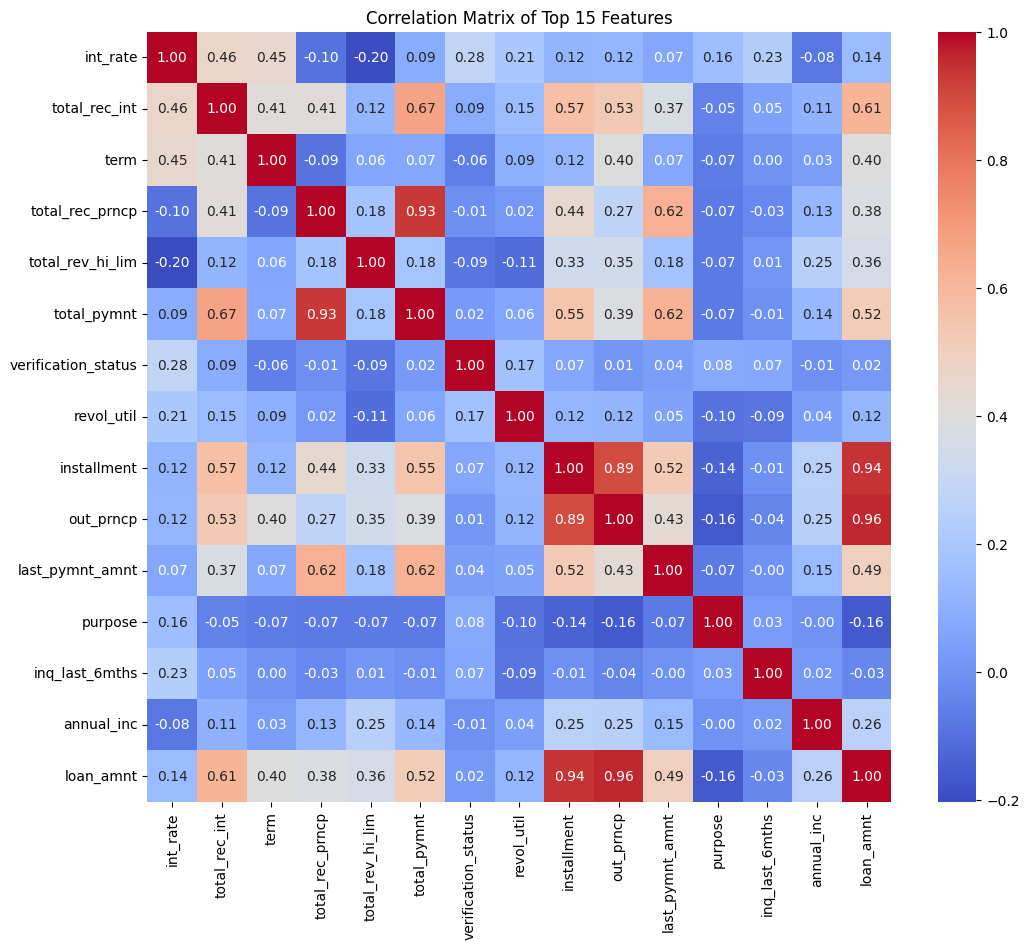

In [58]:
# Get top 15 features
top15_features = top15.index.tolist()
X_top15 = X[top15_features]

# Count correlation matrix
corr_matrix = X_top15.corr()

print("\n💡 Correlation Matrix of Top 15 Features:")
print(corr_matrix, "\n")

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Top 15 Features")
plt.show()




Τα top 15 χαρακτηριστικά εμφανίζουν γενικά χαμηλή έως μέτρια συσχέτιση μεταξύ τους, υποδεικνύοντας ότι παρέχουν σχεδόν ανεξάρτητες πληροφορίες για την πρόβλεψη δανειοδότησης.

Η υψηλότερη συσχέτιση εντοπίζεται μεταξύ int_rate και total_rec_int (~0.46), ενώ τα υπόλοιπα ζεύγη έχουν correlations κάτω από 0.3.

Συνολικά, η χαμηλή συσχέτιση μειώνει τον κίνδυνο multicollinearity και ενισχύει την αξιοπιστία των feature importances που ανέδειξε το Random Forest.

# Subquestion 3

In [59]:
# Dynamic selection of low-correlation features with threshold 0.3
low_corr_features = []
threshold = 0.3  # low correlation

for feature in top15_features:
    # If list is empty (first time)
    if not low_corr_features:
        low_corr_features.append(feature)
    else:
        # Check correlation with already selected features
        if (abs(corr_matrix.loc[feature, low_corr_features]) < threshold).all():
            low_corr_features.append(feature)

print("\n💡 Features with low correlation (<0.3) among them:")
print(low_corr_features)

# Select low-correlation features
X_lowcorr = X[low_corr_features]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_lowcorr, y, test_size=0.30, stratify=y, random_state=42
)

# Train Random Forest
rf_lowcorr = RandomForestClassifier(n_estimators=200, random_state=42)
rf_lowcorr.fit(X_train, y_train)

# Prediction and evaluation
y_pred = rf_lowcorr.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score

print("\n💡 Classification Report with Low-Correlation Features:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importances
importances_lowcorr = pd.Series(rf_lowcorr.feature_importances_, index=X_lowcorr.columns)
print("\n💡 Feature Importances (Low-Correlation Features):")
print(importances_lowcorr.sort_values(ascending=False))




💡 Features with low correlation (<0.3) among them:
['int_rate', 'total_rec_prncp', 'total_rev_hi_lim', 'verification_status', 'revol_util', 'purpose', 'inq_last_6mths', 'annual_inc']

💡 Classification Report with Low-Correlation Features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32421
           1       1.00      1.00      1.00     13274

    accuracy                           1.00     45695
   macro avg       1.00      1.00      1.00     45695
weighted avg       1.00      1.00      1.00     45695

Accuracy: 0.9999124630703579

💡 Feature Importances (Low-Correlation Features):
int_rate               0.910282
total_rev_hi_lim       0.019528
verification_status    0.019162
revol_util             0.018201
purpose                0.010956
total_rec_prncp        0.008942
inq_last_6mths         0.008335
annual_inc             0.004594
dtype: float64


# Question 5

# Subquestion 1

In [60]:
# Import data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Subquestion 2

In [61]:
# Flatten images 28x28 → 784 features
X_train_flat = x_train.reshape(-1, 28*28)
X_test_flat = x_test.reshape(-1, 28*28)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (60000, 784)
X_test_scaled shape: (10000, 784)


# Subquestion 3

In [62]:
# PCA with 300 components
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scaled)  # fit tranform to train set
X_test_pca = pca.transform(X_test_scaled)        # only transform to test set

# Set KNN k values
k_values = [5, 15, 51, 101]

for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train_pca, y_train)

    y_pred = knn.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)

    print(f"K={k}: Accuracy = {acc:.4f}")

K=5: Accuracy = 0.9497
K=15: Accuracy = 0.9436
K=51: Accuracy = 0.9273
K=101: Accuracy = 0.9158


Εφαρμόσαμε PCA με 300 components χρησιμοποιώντας fit_transform μόνο στο train set και transform στο test set, ώστε τα components να προκύπτουν αποκλειστικά από τα δεδομένα εκπαίδευσης. Αν εφαρμόζαμε fit_transform ξεχωριστά στο test set, τα features δεν θα ευθυγραμμίζονταν με το train set, μειώνοντας την ακρίβεια. Αν ενώναμε train και test πριν την PCA, θα είχαμε data leakage και υπερεκτίμηση της απόδοσης. Έτσι διασφαλίζεται η σωστή γενίκευση του KNN.

# Subquestion 4

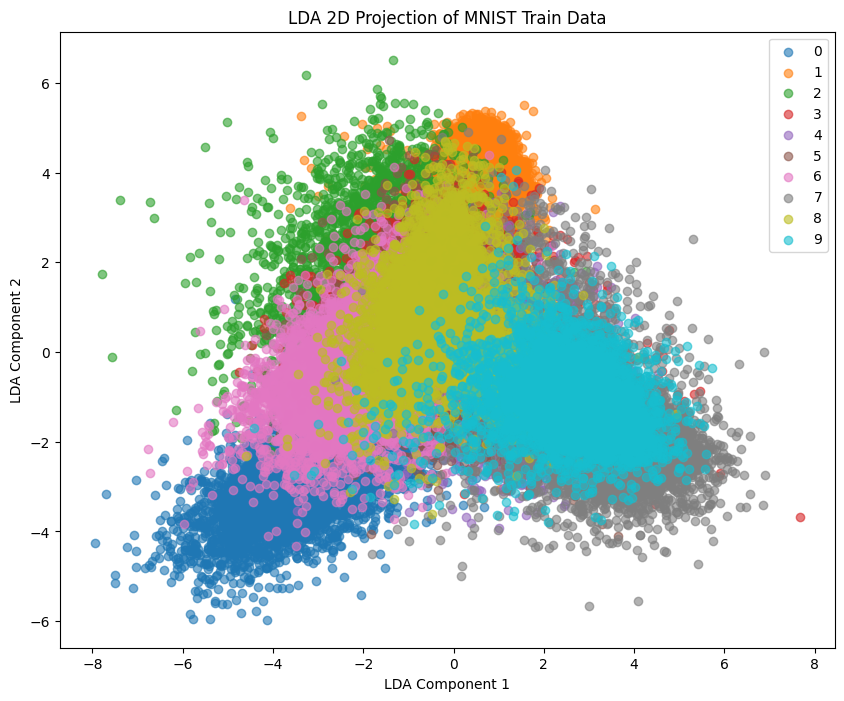

In [63]:
# LDA with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)  # fit tranform to train set
X_test_lda = lda.transform(X_test_scaled)                # transform to test set

# 2D Scatter plot for train set
plt.figure(figsize=(10,8))

# Getting all digits 0-9 (mnist - numbers)
for digit in range(10):

    plt.scatter(
        X_train_lda[y_train==digit, 0], # get samples of specific digit and first component
        X_train_lda[y_train==digit, 1],  # get samples of specific digit and second component
        label=str(digit), alpha=0.6
    )

plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("LDA 2D Projection of MNIST Train Data")
plt.legend()
plt.show()

Από το scatter plot της 2D προβολής με LDA παρατηρούμε ότι οι περισσότερες κλάσεις ψηφίων σχηματίζουν διακριτά clusters, κάτι που υποδεικνύει ότι η LDA διατηρεί καλά τις πληροφορίες που είναι κρίσιμες για τον διαχωρισμό των κλάσεων. Ωστόσο, υπάρχει μερική επικάλυψη μεταξύ ορισμένων ψηφίων που έχουν οπτική ομοιότητα, όπως τα 3 και 5 ή τα 4 και 9, γεγονός που δείχνει ότι η πλήρης γραμμική διαχωριστικότητα σε δύο διαστάσεις δεν είναι απόλυτη. Συνολικά, η LDA παρέχει μια καθαρή οπτική αναπαράσταση της δομής των δεδομένων και είναι αποτελεσματική στη μείωση διαστάσεων με διατήρηση της διαχωριστικής ισχύος των κλάσεων.

# Subquestion 5

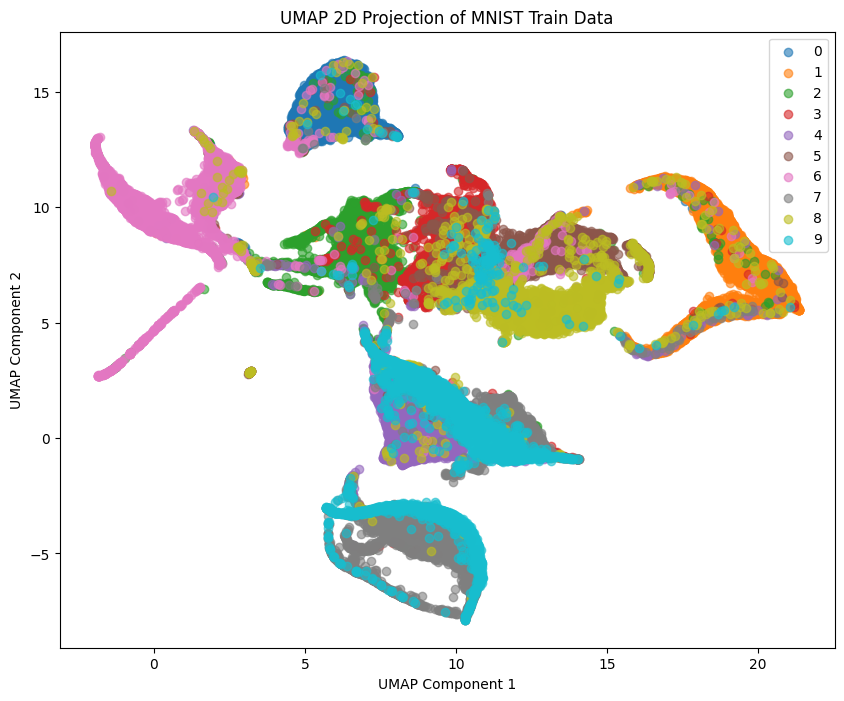

In [64]:
# Create UMAP with 2 components
umap_reducer = umap.UMAP(n_components=2)
X_train_umap = umap_reducer.fit_transform(X_train_scaled) # fit transform to train set
X_test_umap = umap_reducer.transform(X_test_scaled)  # transform only to test set

# 2D Scatter plot for train set
plt.figure(figsize=(10,8))

# Getting all digits 0-9 (mnist - numbers)
for digit in range(10):

    plt.scatter(
        X_train_umap[y_train==digit, 0],  # get samples of specific digit and first component
        X_train_umap[y_train==digit, 1],  # get samples of specific digit and second component
        label=str(digit),
        alpha=0.6
    )

plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP 2D Projection of MNIST Train Data")
plt.legend()
plt.show()

Με βάση τα δύο διαγράμματα φαίνεται ξεκάθαρα ότι η UMAP υπερέχει. Παρέχει μια πολύ πιο καθαρή και χρήσιμη οπτικοποίηση καθώς διατηρεί τις σχέσεις γειτνίασης (δηλαδή, τα ψηφία που είναι "κοντά" μεταξύ τους στον αρχικό χώρο υψηλής διάστασης παραμένουν κοντά) χωρίς να θυσιάζει τον διαχωρισμό των κλάσεων. Αντίθετα, η LDA αποτυγχάνει να διαχωρίσει αποτελεσματικά τα ψηφία, με αποτέλεσμα μια μη-διαφωτιστική, επικαλυπτόμενη προβολή.